# Overview 

### 1) Understand the dataset and describe the challenge (Loading the data, getting its shape, checking for missing values, objectives, etc.)

### 2) Feature Engineering/Data Preprocessing for Model Data Exploration

### 3) Data Exploration (Exploring numerical, categorical data, and plotting)

### 4) Basic Model Building/Model Tuning 

### 5) Results

# 1)  Understand the dataset and describe the challenge

In this notebook we will build an image classification model to identify the emotion being expressed in images of human faces. 

Some important characteristics of the dataset:

- The target variable, emotion, is integer encoded with 7 possible label values. You can find descriptions of the label values in the Data tab of the competition.
- The metric used for the contest is classification accuracy.
- There are 28,709 training images.
- The images are grayscale with a resolution of 48x48.
- Since the images are relatively small and in grayscale, the pixel values for images in the training are stored in a single text file rather than as individual images. The test data is provided in a similar way.

In [1]:
# Importing helpful packages 

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import scikitplot
import seaborn as sns
import keras
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the dataset

path = '/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/'

data = pd.read_csv(path+'icml_face_data.csv')


In [3]:
# Creating a few useful functions

def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [4]:
### Getting the shape of the dataset

print(data.shape)

(35887, 3)


In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
# Exploring the count of emotion 

data.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [7]:
#  Breaking down each class of emotion 

class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

# 2) Feature Engineering/Data Preprocessing for Model Data Exploration

In [8]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline

from collections import Counter
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])
pp = Pipeline([('tk',TomekLinks()),('ros',RandomOverSampler(random_state=0))])
train_image_array, train_image_label = pp.fit_resample(train_image_array.reshape(train_image_array.shape[0],48*48), train_image_label)
print(Counter(train_image_label))
train_image_array = train_image_array.reshape(train_image_array.shape[0], 48, 48)

Counter({0: 7026, 4: 7026, 6: 7026, 2: 7026, 3: 7026, 5: 7026, 1: 7026})


In [9]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')

train_labels = tf.keras.utils.to_categorical(train_image_label)
val_labels = tf.keras.utils.to_categorical(val_image_label)
test_labels = tf.keras.utils.to_categorical(test_image_label)

In [10]:
train_images.shape

(49182, 48, 48, 1)

In [11]:
val_images.shape

(3589, 48, 48, 1)

In [12]:
test_images.shape

(3589, 48, 48, 1)

# 3) Data Exploration (Exploring numerical, categorical data, and plotting)

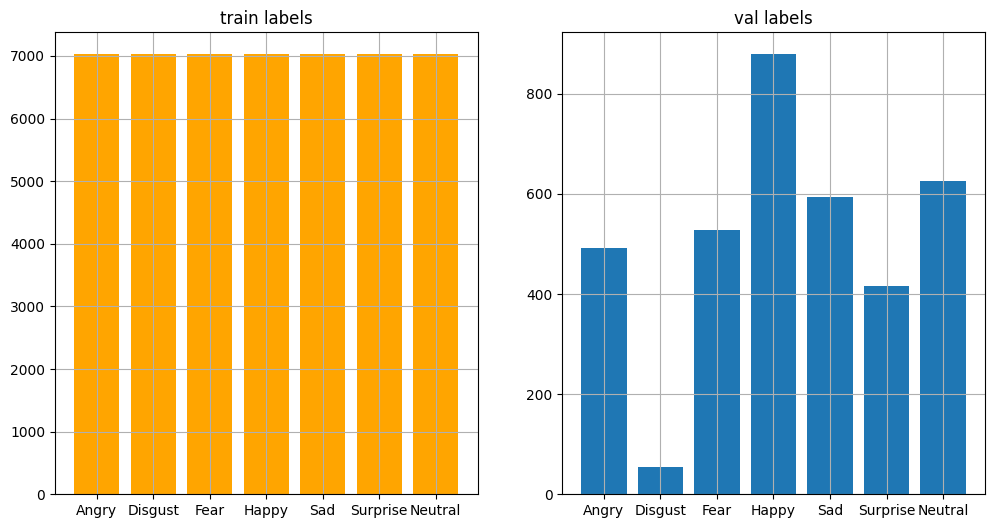

In [13]:
# Visualizing emotion count 

plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

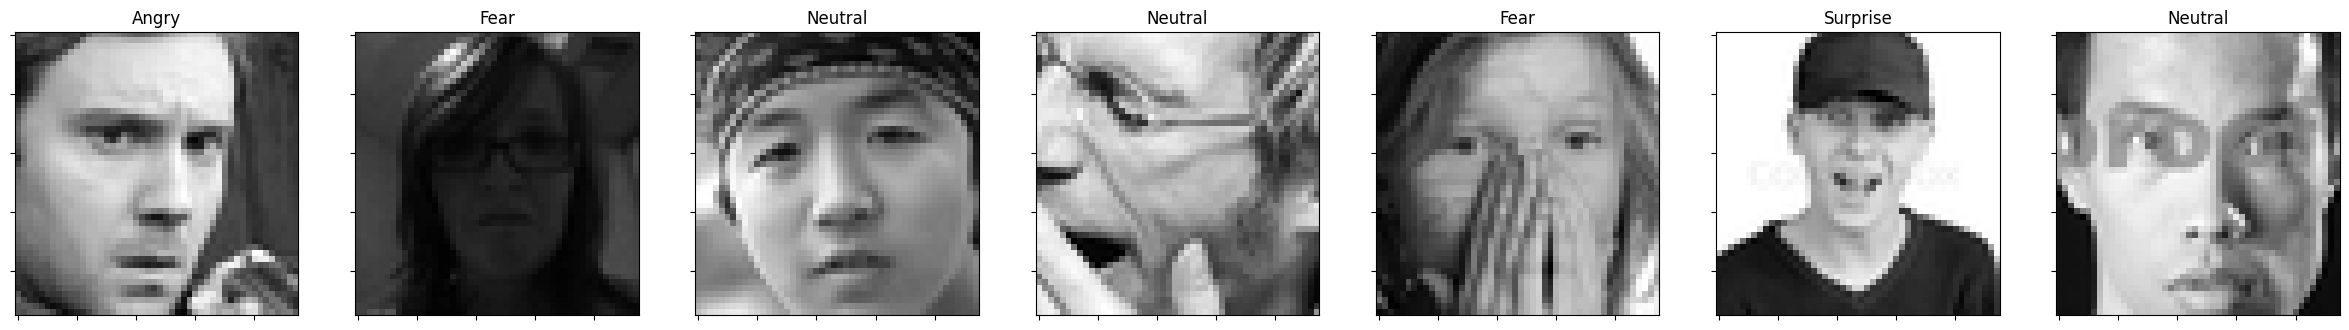

In [14]:
# Visualize the data 

plot_all_emotions()

# 4) Building the model

### Model 1 - CNN

In [15]:
model = Sequential([
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),

    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),

    Flatten(),
    
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [16]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
%time 

history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs
Epoch 1/50


2023-12-18 03:01:59.653691: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


769/769 [==============================] - 28s 19ms/step - loss: 0.2638 - accuracy: 0.2108 - val_loss: 1.5306 - val_accuracy: 0.4071
Epoch 2/50
769/769 [==============================] - 13s 18ms/step - loss: 0.2105 - accuracy: 0.3468 - val_loss: 1.3121 - val_accuracy: 0.4915
Epoch 3/50
769/769 [==============================] - 13s 18ms/step - loss: 0.1858 - accuracy: 0.4188 - val_loss: 1.2033 - val_accuracy: 0.5442
Epoch 4/50
769/769 [==============================] - 14s 18ms/step - loss: 0.1724 - accuracy: 0.4620 - val_loss: 1.1598 - val_accuracy: 0.5553
Epoch 5/50
769/769 [==============================] - 14s 18ms/step - loss: 0.1621 - accuracy: 0.5017 - val_loss: 1.1158 - val_accuracy: 0.5768
Epoch 6/50
769/769 [==============================] - 14s 18ms/step - loss: 0.1531 - accuracy: 0.5356 - val_loss: 1.1026 - val_accuracy: 0.5829
Epoch 7/50
769/769 [==============================] - 13s 17ms/step - loss: 0.1437 - accuracy: 0.5676 - val_loss: 1.0627 - val_accuracy: 0.5954
Epo

In [18]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test accuracy:', test_acc)

113/113 [==============================] - 1s 4ms/step - loss: 1.3713 - accuracy: 0.6202
test accuracy: 0.6202284693717957


### Model 1 Results

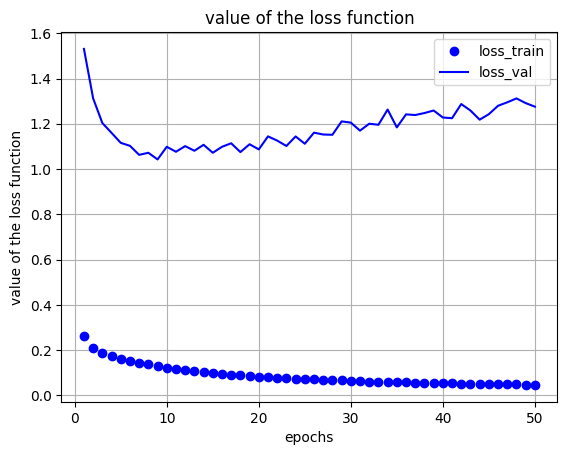

In [19]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

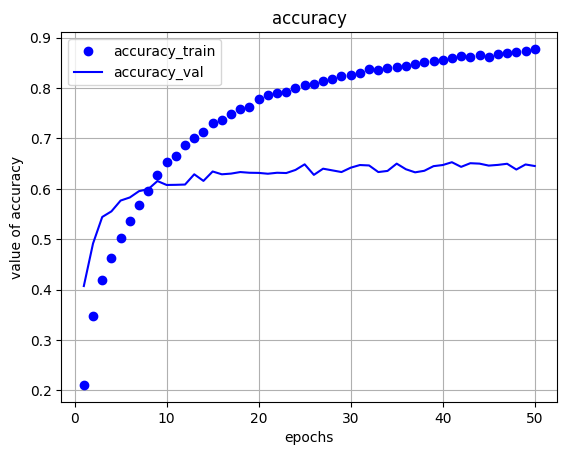

In [20]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

### Model 2 - Image Augmentation

In [21]:
datagen = ImageDataGenerator(
    rescale=1/255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

datagen.fit(train_images)
datagen.fit(val_images)
datagen.fit(test_images)

In [22]:
%time 

h1 = model.fit(datagen.flow(train_images, train_labels),
                    validation_data=datagen.flow(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=40,
                    batch_size=64)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs
Epoch 1/40


2023-12-18 03:13:53.171064: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1537/1537 [==============================] - 37s 23ms/step - loss: 0.2311 - accuracy: 0.3323 - val_loss: 1.3229 - val_accuracy: 0.4996
Epoch 2/40
1537/1537 [==============================] - 35s 23ms/step - loss: 0.1937 - accuracy: 0.3981 - val_loss: 1.2367 - val_accuracy: 0.5274
Epoch 3/40
1537/1537 [==============================] - 35s 23ms/step - loss: 0.1836 - accuracy: 0.4322 - val_loss: 1.1876 - val_accuracy: 0.5500
Epoch 4/40
1537/1537 [==============================] - 35s 23ms/step - loss: 0.1782 - accuracy: 0.4454 - val_loss: 1.1594 - val_accuracy: 0.5600
Epoch 5/40
1537/1537 [==============================] - 35s 23ms/step - loss: 0.1750 - accuracy: 0.4533 - val_loss: 1.1509 - val_accuracy: 0.5709
Epoch 6/40
1537/1537 [==============================] - 35s 23ms/step - loss: 0.1715 - accuracy: 0.4651 - val_loss: 1.1161 - val_accuracy: 0.5779
Epoch 7/40
1537/1537 [==============================] - 35s 23ms/step - loss: 0.1684 - accuracy: 0.4722 - val_loss: 1.1129 - val_accura

In [23]:
history = h1.history
tf.keras.backend.set_value(model.optimizer.learning_rate, 0.0001)

In [24]:
%time 

h2 = model.fit(datagen.flow(train_images, train_labels),
                    validation_data=datagen.flow(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=40,
                    batch_size=64)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.82 µs
Epoch 1/40
1537/1537 [==============================] - 36s 24ms/step - loss: 0.1411 - accuracy: 0.5713 - val_loss: 0.9447 - val_accuracy: 0.6456
Epoch 2/40
1537/1537 [==============================] - 35s 23ms/step - loss: 0.1396 - accuracy: 0.5730 - val_loss: 0.9433 - val_accuracy: 0.6486
Epoch 3/40
1537/1537 [==============================] - 33s 22ms/step - loss: 0.1389 - accuracy: 0.5766 - val_loss: 0.9390 - val_accuracy: 0.6523
Epoch 4/40
1537/1537 [==============================] - 33s 22ms/step - loss: 0.1386 - accuracy: 0.5786 - val_loss: 0.9330 - val_accuracy: 0.6570
Epoch 5/40
1537/1537 [==============================] - 34s 22ms/step - loss: 0.1380 - accuracy: 0.5806 - val_loss: 0.9282 - val_accuracy: 0.6584
Epoch 6/40
1537/1537 [==============================] - 34s 22ms/step - loss: 0.1377 - accuracy: 0.5819 - val_loss: 0.9376 - val_accuracy: 0.6475
Epoch 7/40
1537/1537 [==============================] - 

In [25]:
for k in history.keys():
    history[k] += h2.history[k]

In [26]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test accuracy:', test_acc)

113/113 [==============================] - 1s 4ms/step - loss: 30.0287 - accuracy: 0.2703
test accuracy: 0.2702702581882477


### Model 2 Results 

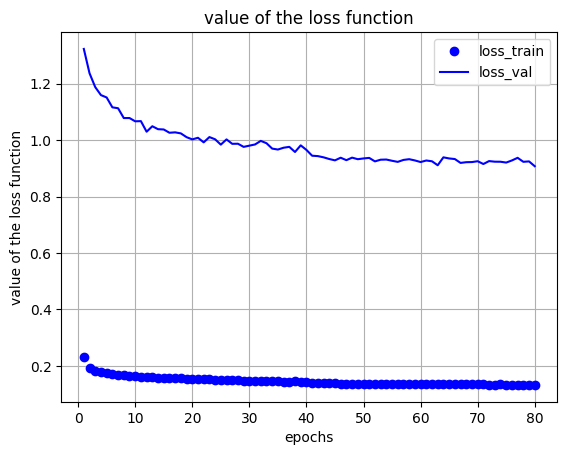

In [27]:
loss = history['loss']
loss_val = history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

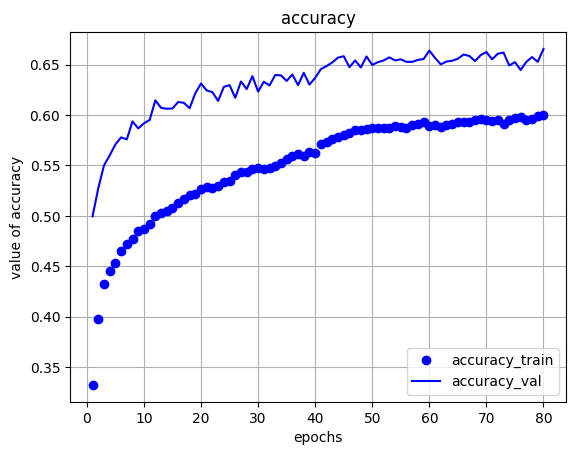

In [28]:
acc = history['accuracy']
acc_val = history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

# 5) Results

1st Model Score: Test Accuracy of .62%
2nd Model Score: Test Accuracy of .53%

The first model using CNN produces a better accuracy and that is our leading model



### Model 3 - Transfer Learning

We will be using the pretrained VGG16 model for feature extraction in our CNN.

In [29]:
def expand_greyscale_image_channels(grey_pil_image):
    grey_image_arr = np.array(grey_pil_image)
    grey_image_arr_3_channel = grey_image_arr.repeat(3, axis=-1)
    return grey_image_arr_3_channel

train_images_rgb = np.zeros(shape=(49182, 48, 48, 3), dtype=int)
for i in range (len(train_images)):
    train_images_rgb[i] = expand_greyscale_image_channels(train_images[i])
    
val_images_rgb = np.zeros(shape=(3589, 48, 48, 3), dtype=int)
for i in range (len(val_images)):
    val_images_rgb[i] = expand_greyscale_image_channels(val_images[i])
    
test_images_rgb = np.zeros(shape=(3589, 48, 48, 3), dtype=int)
for i in range (len(test_images)):
    test_images_rgb[i] = expand_greyscale_image_channels(test_images[i])

In [30]:
base_model = tf.keras.applications.VGG16(
    input_shape=(48,48,3), 
    include_top=False, 
    weights='imagenet'
)

base_model.trainable = False

base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

#### Building the Model

In [31]:
np.random.seed(1)
tf.random.set_seed(1)

model3 = Sequential([
    base_model,
    BatchNormalization(),

    Flatten(),
    
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization_4 (Bat  (None, 1, 1, 512)         2048      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                      

In [32]:
opt = tf.keras.optimizers.Adam(0.0001)
model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Training the Model

In [33]:
%time 

h3 = model3.fit(datagen.flow(train_images_rgb, train_labels),
                    validation_data=datagen.flow(val_images_rgb, val_labels),
                    class_weight = class_weight,
                    epochs=40,
                    batch_size=64)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Epoch 1/40
1537/1537 [==============================] - 62s 38ms/step - loss: 0.3106 - accuracy: 0.1702 - val_loss: 1.7871 - val_accuracy: 0.2992
Epoch 2/40
1537/1537 [==============================] - 59s 38ms/step - loss: 0.2725 - accuracy: 0.2037 - val_loss: 1.7125 - val_accuracy: 0.3232
Epoch 3/40
1537/1537 [==============================] - 59s 38ms/step - loss: 0.2580 - accuracy: 0.2202 - val_loss: 1.6736 - val_accuracy: 0.3405
Epoch 4/40
1537/1537 [==============================] - 58s 38ms/step - loss: 0.2499 - accuracy: 0.2336 - val_loss: 1.6561 - val_accuracy: 0.3391
Epoch 5/40
1537/1537 [==============================] - 59s 38ms/step - loss: 0.2440 - accuracy: 0.2485 - val_loss: 1.6178 - val_accuracy: 0.3600
Epoch 6/40
1537/1537 [==============================] - 59s 38ms/step - loss: 0.2408 - accuracy: 0.2569 - val_loss: 1.6122 - val_accuracy: 0.3689
Epoch 7/40
1537/1537 [==============================] - 61s 

In [34]:
history3 = h3.history

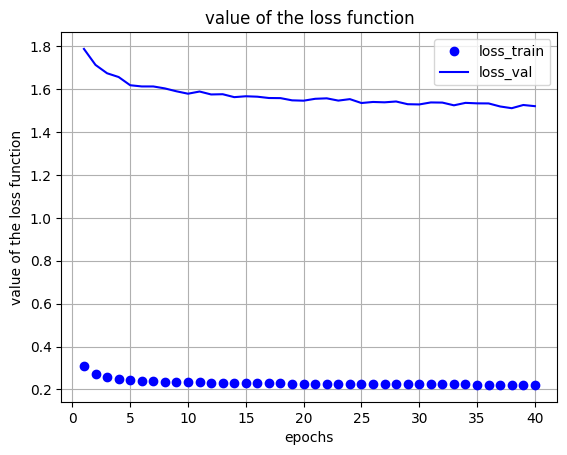

In [35]:
loss = history3['loss']
loss_val = history3['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

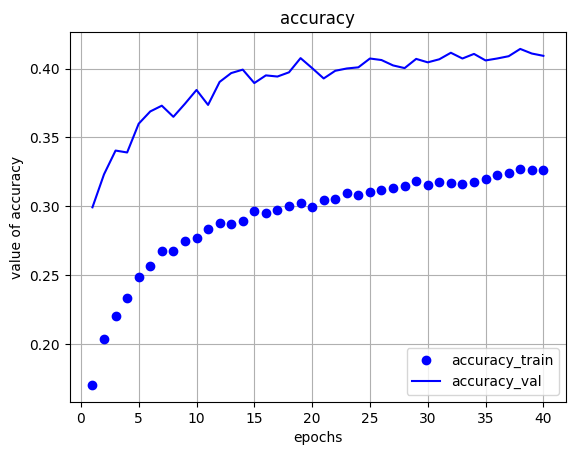

In [36]:
acc = history3['accuracy']
acc_val = history3['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

### Fine Tuning

In [37]:
base_model.trainable = True
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [38]:
%time 

h4 = model3.fit(datagen.flow(train_images_rgb, train_labels),
                    validation_data=datagen.flow(val_images_rgb, val_labels),
                    class_weight = class_weight,
                    epochs=40,
                    batch_size=64)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 19.8 µs
Epoch 1/40
1537/1537 [==============================] - 66s 42ms/step - loss: 0.2051 - accuracy: 0.3688 - val_loss: 1.3383 - val_accuracy: 0.4826
Epoch 2/40
1537/1537 [==============================] - 64s 41ms/step - loss: 0.1907 - accuracy: 0.4144 - val_loss: 1.2930 - val_accuracy: 0.5280
Epoch 3/40
1537/1537 [==============================] - 63s 41ms/step - loss: 0.1830 - accuracy: 0.4411 - val_loss: 1.3133 - val_accuracy: 0.5043
Epoch 4/40
1537/1537 [==============================] - 63s 41ms/step - loss: 0.1771 - accuracy: 0.4613 - val_loss: 1.1899 - val_accuracy: 0.5667
Epoch 5/40
1537/1537 [==============================] - 64s 41ms/step - loss: 0.1718 - accuracy: 0.4773 - val_loss: 1.1559 - val_accuracy: 0.5818
Epoch 6/40
1537/1537 [==============================] - 63s 41ms/step - loss: 0.1674 - accuracy: 0.4929 - val_loss: 1.1493 - val_accuracy: 0.5871
Epoch 7/40
1537/1537 [==============================] - 64s 

In [39]:
pred_test_labels = model3.predict(test_images_rgb)

df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

113/113 [==============================] - 1s 11ms/step


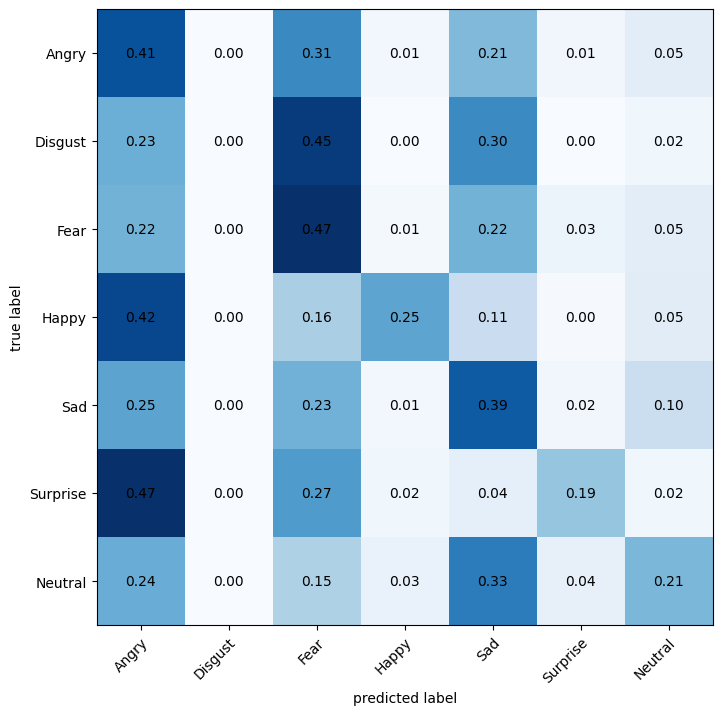

In [40]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

In [41]:
test_loss, test_acc = model3.evaluate(test_images_rgb, test_labels)
print('test accuracy:', test_acc)

113/113 [==============================] - 2s 12ms/step - loss: 13.5703 - accuracy: 0.3096
test accuracy: 0.3095569908618927
